In [1]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=True)
model.eval()


Using cache found in /home/ujjwal/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /home/ujjwal/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

Using cache found in /home/ujjwal/.cache/torch/hub/pytorch_vision_v0.10.0


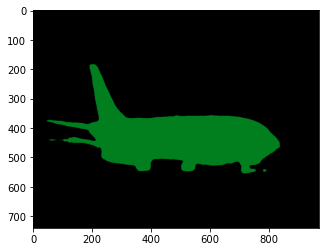

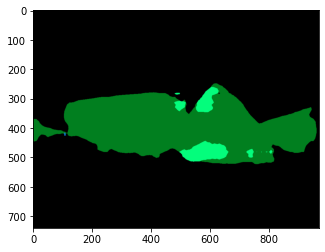

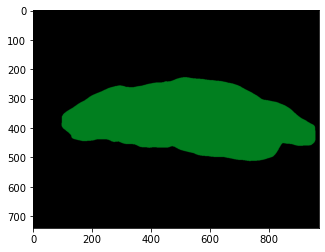

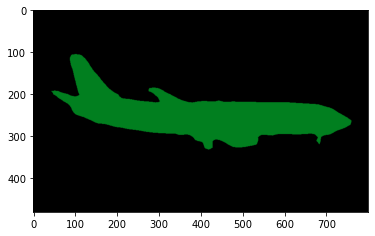

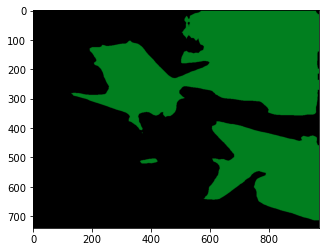

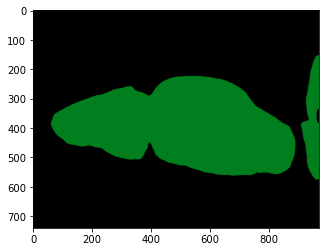

In [8]:
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the DeepLab model (choose the appropriate variant)
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.eval()

# Define the path to your aircraft images folder
folder_path = 'aircrafts'

# Define the transformation for preprocessing
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Iterate through the images in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Load and preprocess the image
        input_image = Image.open(os.path.join(folder_path, filename)).convert("RGB")
        input_tensor = preprocess(input_image)
        input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model

        # Move the input and model to GPU for speed if available
        if torch.cuda.is_available():
            input_batch = input_batch.to('cuda')
            model.to('cuda')

        # Perform inference and get segmentation predictions
        with torch.no_grad():
            output = model(input_batch)['out'][0]
        output_predictions = output.argmax(0)

        # Create a color palette for visualization
        palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
        colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
        colors = (colors % 255).numpy().astype("uint8")

        # Plot the semantic segmentation predictions with colors representing classes
        r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
        r.putpalette(colors)

        plt.imshow(r)
        plt.show()


with their respective input images


Using cache found in /home/ujjwal/.cache/torch/hub/pytorch_vision_v0.10.0


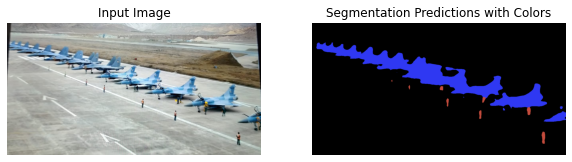

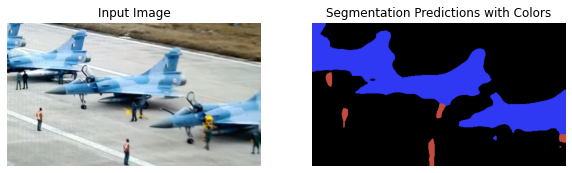

In [1]:
import os
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the DeepLab model (choose the appropriate variant)
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.eval()

folder_path = 'aircrafts'
output_folder = 'output_predictions'  # Folder to save output segmentation masks

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Define the transformation for preprocessing
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the color palette for visualization
palette = torch.tensor([3 ** 25 - 1, 3 ** 15 - 1, 3 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# Iterate through the images in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.jpeg') or filename.endswith('.png'):
        # Load and preprocess the image
        input_image = Image.open(os.path.join(folder_path, filename)).convert("RGB")
        input_tensor = preprocess(input_image)
        input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model

        # Move the input and model to GPU for speed if available
        if torch.cuda.is_available():
            input_batch = input_batch.to('cuda')
            model.to('cuda')

        # Perform inference and get segmentation predictions
        with torch.no_grad():
            output = model(input_batch)['out'][0]
        output_predictions = output.argmax(0)

        # Convert the output predictions to a NumPy array
        output_predictions_np = output_predictions.byte().cpu().numpy()

        # Apply the color palette to the segmentation mask
        output_mask = Image.fromarray(output_predictions_np)
        output_mask.putpalette(colors)

        # Save the semantic segmentation with colors in the output folder
        output_mask.save(os.path.join(output_folder, filename.split('.')[0] + '_segmentation.png'))

        # Plot the input image and semantic segmentation predictions with colors
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(input_image)
        axs[0].axis('off')
        axs[0].set_title('Input Image')

        axs[1].imshow(output_mask)
        axs[1].axis('off')
        axs[1].set_title('Segmentation Predictions with Colors')

        plt.show()


In [9]:
import os
import numpy as np
from PIL import Image

ground_truth_folder = 'output_predictions'  # Folder containing ground truth segmentation masks

# Initialize variables for accuracy calculation
iou_total = 0.0
num_images = 0

# Iterate through the images in the ground truth folder
for filename in os.listdir(ground_truth_folder):
    if filename.endswith('_segmentation.png'):
        # Load the predicted segmentation mask
        pred_mask_path = os.path.join(ground_truth_folder, filename)
        pred_mask = np.array(Image.open(pred_mask_path))

        # Load the corresponding ground truth segmentation mask
        gt_mask_path = os.path.join(ground_truth_folder, filename.replace('_mask.png', '.png'))
        gt_mask = np.array(Image.open(gt_mask_path))

        # Compute IoU for this image
        intersection = np.logical_and(pred_mask, gt_mask)
        union = np.logical_or(pred_mask, gt_mask)
        iou_value = np.sum(intersection) / np.sum(union)

        # Accumulate IoU values for accuracy calculation
        iou_total += iou_value
        num_images += 1

# Calculate mean IoU (mIoU) for the batch
mIoU = iou_total / num_images if num_images > 0 else 0.0
print(f"Mean Intersection over Union (mIoU): {mIoU}")


Mean Intersection over Union (mIoU): nan


/tmp/ipykernel_35107/1824117341.py:25: RuntimeWarning: invalid value encountered in scalar divide
  iou_value = np.sum(intersection) / np.sum(union)


In [11]:
import os
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

# Load the DeepLab model (choose the appropriate variant)
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.eval()

folder_path = 'aircrafts'
ground_truth_folder = 'output_predictions'  # Folder containing ground truth segmentation masks

# Define the transformation for preprocessing
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize variables for accuracy calculation
iou_total = 0.0
num_images = 0
iou_per_image = []

for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Load and preprocess the image
        input_image = Image.open(os.path.join(folder_path, filename)).convert("RGB")
        input_tensor = preprocess(input_image)
        input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model

        # Move the input and model to GPU for speed if available
        if torch.cuda.is_available():
            input_batch = input_batch.to('cuda')
            model.to('cuda')

        # Perform inference and get segmentation predictions
        with torch.no_grad():
            output = model(input_batch)['out'][0]
        output_predictions = output.argmax(0).cpu().numpy()

        # Load corresponding ground truth segmentation mask
        gt_mask = Image.open(os.path.join(ground_truth_folder, filename.split('.')[0] + '_segmentation.png'))
        gt_mask = np.array(gt_mask)

        # Compute IoU for this image
        intersection = np.logical_and(output_predictions, gt_mask)
        union = np.logical_or(output_predictions, gt_mask)
        
        # Handle cases where union is empty (division by zero)
        if np.sum(union) == 0:
            iou_value = 0.0  # Set IoU to 0 for empty union
        else:
            iou_value = np.sum(intersection) / np.sum(union)

        # Accumulate IoU values for accuracy calculation
        iou_total += iou_value
        num_images += 1

        # Append IoU value for this image to the list
        iou_per_image.append(iou_value)


# Calculate mean IoU (mIoU) for the batch
mIoU = iou_total / num_images if num_images > 0 else 0.0
print(f"Mean Intersection over Union (mIoU): {mIoU}")

# Print IoU for each predicted segmentation
print("IoU per predicted segmentation:")
for i, iou in enumerate(iou_per_image, 1):
    print(f"Image {i}: {iou}")


Using cache found in /home/ujjwal/.cache/torch/hub/pytorch_vision_v0.10.0


Mean Intersection over Union (mIoU): 0.6363636363636364
IoU per predicted segmentation:
Image 1: 1.0
Image 2: 1.0
Image 3: 1.0
Image 4: 1.0
Image 5: 0.0
Image 6: 1.0
Image 7: 1.0
Image 8: 1.0
Image 9: 0.0
Image 10: 0.0
Image 11: 0.0
